# Noise with noise spectrum

nothing in particular

In [3]:
%reset -f
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as st
import scipy.special as spec
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm
import scipy.integrate as integrate
%matplotlib inline

# Constants
pi2 = 2*np.pi
pi = np.pi

# Set style of plots
ticksize= 12
titlesize = 18
mpl.rcParams.update({'font.size':ticksize }) 
mpl.rcParams.update({'legend.fontsize':ticksize })# legend
mpl.rcParams.update({'ytick.labelsize':ticksize })
mpl.rcParams.update({'xtick.labelsize':ticksize})
mpl.rcParams.update({'axes.titlesize':titlesize})       # Title
mpl.rcParams.update({'axes.labelsize':titlesize})    # x,y,cbar labels
mpl.rcParams.update({'figure.titlesize' :titlesize})
mpl.rcParams.update({'savefig.bbox':'tight'})
mpl.rcParams.update({'axes.formatter.limits':[-4,4]})
mpl.rcParams.update({'figure.figsize':[6,5]})
mpl.rcParams.update({'mathtext.fontset':'cm'})
mpl.rcParams.update({'font.style':'normal'})
# mpl.interactive(True)


mpl.rcParams.update({'axes.formatter.useoffset':False})   # no offset of axis
mpl.rcParams.update({'axes.formatter.use_mathtext':True}) # Change from 1e4 to 10^4 

def sci_not(num,dec):
    exp = int(np.log10(num)+100)-100
    sci = (r"$%.10f"%(num/10**exp))[:dec+2+1*(dec>0)]+r"\cdot10^{%d}$"%exp
    return sci


[-2. -1.  0.  1.]
[-2 -1  0  1]


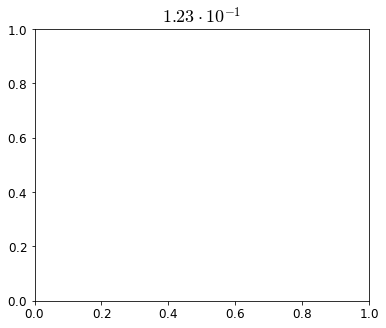

In [2]:
int(1.9)
plt.figure()
plt.title(sci_not(.12345,2))
tall = [0.01,0.1,1,10]
print(np.log10(tall))
print(np.int32(np.log10(tall)))



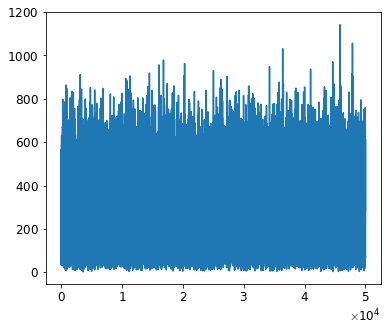

In [3]:
N=1e5+1

#Gaussian noise
x = np.random.normal(0,1,int(N))
fft = np.fft.rfft(x)
plt.figure()
plt.plot(np.abs(fft))

I do N measurements, the error should fall like 1/N <br>
If I always to this, I should get 

In [4]:
# How often do particles pass?
tsep = 25e-9
fbunch= 1/tsep
print("Bunches are separated by %.2e s"%tsep)
print("That means the bunches come at a frequency of %.2e Hz"%fbunch)

freq_standard = 4e6
d_bpm = 217e-5 # Noise of each measurement
d_0 = 4.8e-5

#Accuracy ≈ 50 μm (adt) 
def noise_adt(highCutoff,fbunch=fbunch,G=1):
    # too simple method:
    N = 1+1*np.floor(fbunch/highCutoff).astype(np.int32)
    return d_bpm/np.sqrt(N)   *G

#     return np.abs(np.mean(np.random.normal(0,d_bpm,N)))
#     return np.sqrt(N*d_bpm**2/N)
noise_adt(1e6,1e6)

def integrate_log(func,a,b,N,args=(1)):
    if a<=0   : a=0.1
    if b>1e50 : b=1e50
    x = np.logspace(np.log10(a),np.log10(b),N)
    dx = np.diff(x)*0.5
    return np.sum((func(x[:-1],args) + func(x[1:],args))*dx)
    

# Machine noise
MACH_NOISE_FAC = 1
def noise_mach(freq):
    if freq < 1e5:
        return 1e-3/(freq)
    elif freq < 4e5:
        return 1e-8/((freq/1e5)**2.5)
    elif freq<1e9:
        return 1e-10/(freq/1e6)**1  
    else:
        return noise_mach(1e9-1)/(freq/(1e9))**2


def noise_mach_1(freq,MACH_NOISE_FAC = 1):
    return noise_mach(freq)*MACH_NOISE_FAC
    
def noise_mach_n(freq,MACH_NOISE_FAC = 1):
    res = np.zeros_like(freq)
    for i in range(np.size(freq)):
        res[i]=noise_mach(freq[i])*MACH_NOISE_FAC
    return res

def noise_mach_n2(freq,MACH_NOISE_FAC = 1):
    res = np.zeros_like(freq)
    for i in range(np.size(freq)):
        res[i]=noise_mach(freq[i])**2*MACH_NOISE_FAC**2
    return res


bool_squared = 1
if bool_squared :
    MACH_NOISE_FAC = d_0/np.sqrt(integrate_log(noise_mach_n2,1,1e20,10000,args=(1)))
    print(MACH_NOISE_FAC)
    print(np.sqrt(integrate_log(noise_mach_n2,1,1e25,10000,args=MACH_NOISE_FAC)))
else:
    MACH_NOISE_FAC = d_0/integrate_log(noise_mach_n,1,1e30,10000,args=(1))
    print(integrate_log(noise_mach_n,1,1e30,10000,args=(MACH_NOISE_FAC)))


Bunches are separated by 2.50e-08 s
That means the bunches come at a frequency of 4.00e+07 Hz
0.0479999250934
4.80001431799e-05


In [5]:
n=30
freqmin=2
freqmax= 1e10
freq = np.logspace(np.log10(freqmin),np.log10(freqmax),n)
dfreq = np.diff(freq) # TO BE CHANGED !!!!
dfreq = np.concatenate((dfreq,[dfreq[-1]]))

coeff = noise_mach_n(freq)
highpasscoeff=np.cumsum((dfreq* coeff)[::-1])[::-1] *2/pi
machine_undampable=np.zeros(n) #+ integrate.quad(noise_mach,freqmax+5,np.inf)[0] *2/pi
machine_dampable = np.zeros(n)
# machine_noise_rms=np.zeros(n) #+ integrate.quad(noise_mach,freqmax+5,np.inf)[0] *2/pi

for i in range(n):
    if bool_squared:
        machine_undampable[i] = np.sqrt(integrate_log(noise_mach_n2,freq[i],1e25,20000,args=MACH_NOISE_FAC))
        machine_dampable[i] = np.sqrt(integrate_log(noise_mach_n2,1,freq[i],20000,args=MACH_NOISE_FAC))
    else:
        machine_undampable[i] = integrate_log(noise_mach_n,freq[i],1e30,10000,args=MACH_NOISE_FAC)
    
#     a = integrate.quad(noise_mach,freq[i],freq[i]*width)[0]        *2/pi
#     b = integrate.quad(noise_mach,freq[i]*width,freq[i]*width**2)[0]   *2/pi
#     print("freq %.2e, a=%.1e , b=%.1e"%(freq[i],a,b))


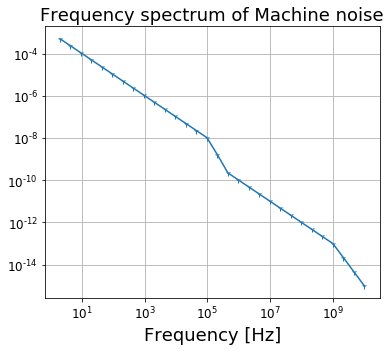

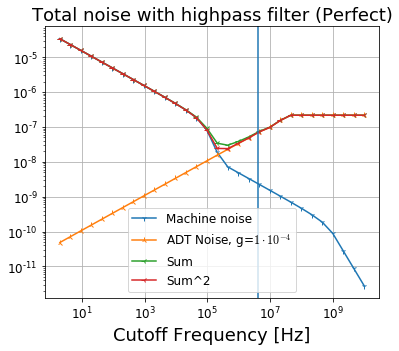

In [6]:

plt.figure()
plt.loglog(freq,coeff,'-1')
plt.title("Frequency spectrum of Machine noise")
plt.xlabel("Frequency [Hz]")
plt.grid(True)




plt.figure()
# plt.loglog(freq,highpasscoeff,'-1') 
G = 0.0001
plt.loglog(freq,machine_undampable,'-1',label="Machine noise") 
plt.loglog(freq,noise_adt(freq,fbunch,G=G),'-2',label='ADT Noise, g=%s'%sci_not(G,0))
plt.loglog(freq,machine_undampable+noise_adt(freq,fbunch,G=G),'-3',label="Sum" )
plt.loglog(freq,np.sqrt(machine_undampable**2+noise_adt(freq,fbunch,G=G)**2),'-3',label="Sum^2" )
# plt.loglog(freq,machine_dampable,'-1',label="Machine dampable noise")
plt.legend(loc=0)
plt.axvline(x=freq_standard)
plt.title("Total noise with highpass filter (Perfect)")
plt.xlabel("Cutoff Frequency [Hz]");
plt.grid(True)
plt.savefig("00_Plots/NoiseWithHP_g%.0e.eps"%G)


In [7]:
print(machine_undampable)
print(d_0-machine_dampable)

[  3.39408871e-05   2.30938199e-05   1.57131764e-05   1.06911088e-05
   7.27379569e-06   4.94829224e-06   3.36553590e-06   2.28795121e-06
   1.55378792e-06   1.05283766e-06   7.09877348e-07   4.73330182e-07
   3.07348988e-07   1.85668256e-07   8.18462911e-08   1.85394065e-08
   7.16280566e-09   4.87286194e-09   3.31434313e-09   2.25331205e-09
   1.53050367e-09   1.03741556e-09   7.00009841e-10   4.67560536e-10
   3.04897354e-10   1.86520837e-10   8.86452223e-11   2.79269068e-11
   8.79735106e-12   2.77128386e-12]
[  1.40589275e-05   5.92087037e-06   2.64503765e-06   1.20602381e-06
   5.54581973e-07   2.55993958e-07   1.18387121e-07   5.48128886e-08
   2.54082853e-08   1.18007444e-08   5.50195371e-09   2.58584875e-09
   1.23558645e-09   6.10195924e-10   3.20370016e-10   2.53623422e-10
   2.49993708e-10   2.49087300e-10   2.48299580e-10   2.47547759e-10
   2.46793199e-10   2.46018482e-10   2.45215224e-10   2.44379670e-10
   2.43510118e-10   2.42605777e-10   2.41665766e-10   2.40690860e-1

5.74470559282e-18
5.79548803772e-15
5.74470559282e-18
5.79548803772e-15


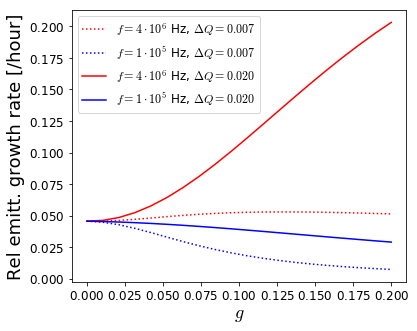

In [9]:
def lebfac(dq,g):
    a = pi2**2*(1-g/2)*dq**2
    return a*(1-g/2)/(a+(g/2)**2)


# New figure

n = 20
tot_noise = np.zeros(n)
Gs = np.linspace(0,.2,n)
plt.figure()
for jq,dq in enumerate([0.007,0.02]):
    for jf,f in enumerate([freq_standard,1e5]):
        for i,G in enumerate(Gs):
            if bool_squared:
                val0 = np.sqrt(integrate_log(noise_mach_n2,f,1e30,10000,args=MACH_NOISE_FAC)) # what cannot be damped
                val1 = np.sqrt(integrate_log(noise_mach_n2,1,f,10000,args=MACH_NOISE_FAC))  # what can be damped
            else:
                val0 = integrate_log(noise_mach_n,f,1e30,10000,args=MACH_NOISE_FAC) # what cannot be damped
                val1 = integrate_log(noise_mach_n2,1,f,1000,args=MACH_NOISE_FAC)    # what can be damped
            val2 = noise_adt(f,G=G)
    #         print(val0,val1,val2,val0**2+val1**2,val2**2)
#             print(val0,val1,val0**2+val1**2,val2,lebfac(dq,G))
            tot_noise[i] = val0**2 + (val1**2 + val2**2) * lebfac(dq,G)
        plt.plot(Gs,tot_noise*11000*3600*0.5,ls=[':','-','--'][jq],c=['r','b'][jf],label=r"$f=$%s Hz, $\Delta Q=%.3f$"%(sci_not(f,0),dq))
plt.legend(loc=0)
plt.ylabel("Rel emitt. growth rate [/hour]")
plt.xlabel(r'$g$')
# plt.ylim(0,0.07)
plt.savefig("00_Plots/NoiseWithHP_Emitgrowth2.png")


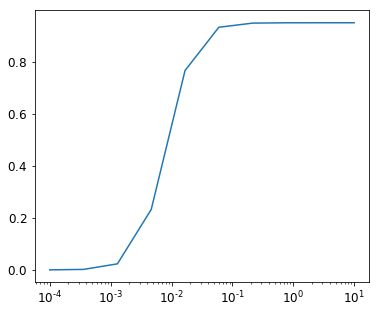

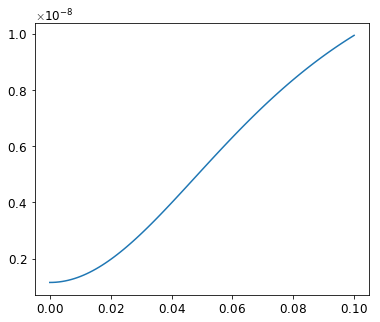

In [11]:
# Lebedev study
plt.figure()
x= np.logspace(-4,1,10)
plt.semilogx(x,lebfac(x,0.1))
plt.figure()
G = np.linspace(0,0.1,100)
plt.plot(G,0.5*(d_0**2+G**2*d_bpm**2)*lebfac(0.007,G))



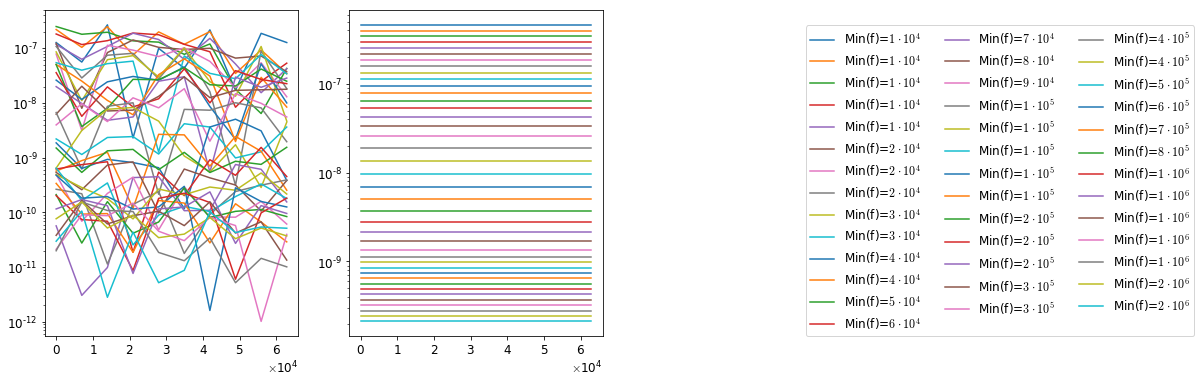

In [22]:
# How does the noise look like? (perhaps)
times = np.linspace(0,pi2*1e4,10)
ones = np.ones_like(times)
wt2d = np.outer(freq,times)
phi2d = np.outer(np.random.uniform(0,pi2,n),ones)
sinp2d= np.sin(wt2d+phi2d)
ones2d= np.ones_like(sinp2d)
coeff2d=np.outer(coeff,ones)


fig= plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i in range(min(n,40)):
#     print(np.sum(coeff[i:]))#*np.sin(freq[:i]+np.random.uniform(0,pi2,i))))
#     print(np.sin(np.outer(freq[i:],times)).shape)
#     print(np.sum(np.sin(wt2d),axis=0).shape)
#     print(times.shape)
#     plt.plot(times,np.sum(np.outer(coeff[i:],ones)*\
#                           np.sin(np.random.uniform(0,pi2,n-1) + ,axis=0)\
    p = ax1.semilogy(times,np.abs(np.sum(coeff2d[i:,:]*sinp2d[i:,:],axis=0)),\
                          label="Min(f)=%s"%(sci_not(freq[i],0)))
    ax2.semilogy(times,2/pi*np.sum(coeff2d[i:,:]*ones2d[i:,:],axis=0),c=p[0].get_color())
    
ax1.legend(loc=(3,0),ncol=3)

0.707106781187
0.342301569915
0.381386820122
0.249179852265
0.502010862603
0.743054434962
0.646106770027
0.808787215958
0.802367380855
0.936972020375
0.848757181453
0.728448639652
0.782304502565
0.627397039699
0.522480256846
0.335673904813
0.38453211612
0.294574301357
0.318141183836
0.252397284182
0.130134883324
0.209121661021
0.275913364772
0.178881734839
0.316669682715
0.448838412713
0.495675244978
0.555948077661
0.424398501299
0.451413727752
0.317672777569
0.426361475153
0.418941142943
0.504255920915
0.611452287268
0.641558103868
0.661112072715
0.541664351846
0.627207093752
0.611005612437
0.713870978676
0.751296642197
0.843037250012
0.922329417924
0.846752314438
0.914950861854
0.903632855078
0.971877589375
1.0583378993
1.07475345253
1.10486767564
1.13780426772
1.18089120332
1.17345093301
1.24132181292
1.20404353413
1.20089586375
1.19523741806
1.25492644831
1.22865783788
1.14753943435
1.10829557378
1.01089513555
1.09073687916
1.02771695412
1.09763707627
1.03922028715
1.06115314586
1.

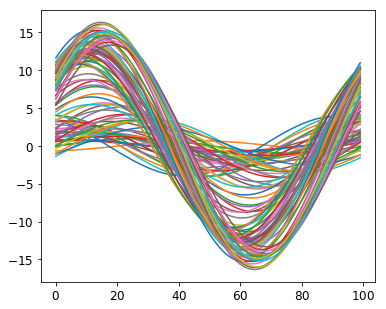

In [185]:
numt= 10
n=100
x = np.zeros(n)
y = np.linspace(0,pi2,n,endpoint=False)
plt.figure()
for i in range(n):
    x+= np.sin(y + np.random.uniform(0,pi2))
    print(np.std(x) /np.sqrt(i+1))
    plt.plot(x)